# Solution Planning


## Business Problem
   **What is the business problem?**

    Select the most valuable customers to join the "Loyals" loyalty program.

    Answering business questions to the marketing team.

## Output
**What will I deliver? / Where does the business team want to see it?**

List in xls / send by email. It must contain customers who will join Loyals (loyalty program).
Format:
client_id	is_loyal

    │1	│yes
    │2	│no
    
**PDF report answering business questions / send by email and present to the marketing team:**

    Who are the people eligible to participate in the Loyals program?
    How many customers will be part of the group?
    What are the main characteristics of these customers?
    What is the percentage of revenue contribution from Loyals?
    What is the expected revenue for this group for the coming months?
    What are the conditions for a person to be eligible for Loyals?
    What are the conditions for a person to be removed from Loyals?
    What is the guarantee that the Loyals program is better than the rest of the base?
    What actions can the marketing team take to increase revenue?

### Input

Data sources: Dataset "Ecommerce.csv", containing e-commerce sales for the period of one year.

Tools: Python 3.8.12, Jupyter Notebook, Git, Github.

Process
Type of problem: Separation of customers by groups.

Main methods: clustering.

**Business Questions:**

    Who are the people eligible to participate in the Loyals program?
    
    What does it mean to be eligible? / What are higher "value" customers? (depending on business area)
    Invoicing:
    
   - High average ticket
       High LTV (sum of customer revenue)
       
       Low recency (time since last purchase)
       
       High basket size (qty products purchased per purchase)
       
       Low churn probability (would use the output of a model)
       
       High LTV Prediction (would use output from a model)
       
       High propensity to buy (would use the output of a model)
       
              
   - Cost:
        Low return rate
        
   - Shopping experience:
   
        High average of the evaluations

## Solution Benchmarking
Desk Research
Reading articles on customer segmentation on the internet to understand what the market is doing.

Identify from market solutions, with the business team, what we can do as an MVP.

RFM segmentation model.

# Imports

In [50]:
import re
import inflection
import pandas            as pd
import seaborn           as sns
import datetime          as dt
from matplotlib  import pyplot as plt

from sklearn import cluster as c
from sklearn import metrics as m
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Helper Functions

In [2]:
# Função para formatar notação científica
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Tamanho dos Graficos
sns.set(style = "darkgrid")
sns.set(rc={"figure.figsize":(15, 10)})
#pd.options.display.float_format = "{:,.2f}".format


## Load Data

In [3]:
df_raw = pd.read_csv('data/ecommerce.csv',encoding='unicode_escape')

In [4]:
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# Data Description

In [5]:
df1 = df_raw.copy()

## Rename Columns

In [6]:
#Renomear as colunas do dataset microdados
cols_old = list(df1)


#Função para renomear colunas

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old) )

#Rename
df1.columns = cols_new

## Data Dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## Data Dtypes

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Drop NA

In [10]:
df1 = df1.dropna()

The most NA values are in the customer_id column. 
In this first step, I decided to exclude the NA values, as it isn't possible to fill in these values without further information.

## Change dtypes

In [11]:
# invoicedate
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

#customerid
df1['customer_id'] = df1['customer_id'].astype('int64')
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [13]:
#central tendency - mean, median, 
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, 
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()) ).T

#Merge
n = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
n.columns = ['attributes', 'min', 'max', 'range','mean', 'median', 'std','skew','kurtosis']
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0000,80995.0000,161990.0000,12.0613,5.0000,248.6931,0.1827,94317.5637
1,unit_price,0.0000,38970.0000,38970.0000,3.4605,1.9500,69.3151,452.2190,246924.5430
2,customer_id,12346.0000,18287.0000,5941.0000,15287.6906,15152.0000,1713.5982,0.0298,-1.1800


### Categorical Attributes

In [14]:
# problem: The invoice has numbers and letters

df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

#Check if all invoices are letter
print(f'total de invoices com letras: {len(df_letter_invoices)}')

#Check if all invoices are negative
print(f'total de invoices com valores negativos: {len(df_letter_invoices[ df_letter_invoices["quantity"] < 0 ])}')

total de invoices com letras: 8905
total de invoices com valores negativos: 8905


### Stoke_code

In [15]:
at_least_one_string = len(cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x: bool( re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())

cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x:  bool( re.search( '^[a-zA-z]+$', x))),'stock_code'].unique()

#Ação
# Remover 'POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

### Country

In [16]:
len(df1['country'].unique())

37

In [17]:
# country x purchases
df1['country'].value_counts(normalize=True)

United Kingdom         0.8895
Germany                0.0233
France                 0.0209
EIRE                   0.0184
Spain                  0.0062
Netherlands            0.0058
Belgium                0.0051
Switzerland            0.0046
Portugal               0.0036
Australia              0.0031
Norway                 0.0027
Italy                  0.0020
Channel Islands        0.0019
Finland                0.0017
Cyprus                 0.0015
Sweden                 0.0011
Austria                0.0010
Denmark                0.0010
Japan                  0.0009
Poland                 0.0008
USA                    0.0007
Israel                 0.0006
Unspecified            0.0006
Singapore              0.0006
Iceland                0.0004
Canada                 0.0004
Greece                 0.0004
Malta                  0.0003
United Arab Emirates   0.0002
European Community     0.0001
RSA                    0.0001
Lebanon                0.0001
Lithuania              0.0001
Brazil    

# Filtering Variable

In [18]:
df2 = df1.copy()

# Feature Engeneering

In [19]:
df3 = df2.copy()

In [20]:
  
#create the referente table with uniques customer_id (and reset index)
df_ref = df3.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True).copy()

**Let's to create the RFM Features**

## Monetary

In [21]:
# Gross Revenue: (quantity * price of each purchase)
df3['monetary'] = df3['quantity'] * df3['unit_price']
df3.sample(2)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,monetary
538842,581418,23153,ZINC SWEETHEART WIRE LETTER RACK,4,2017-12-06,3.7500,17451,United Kingdom,15.0000
85169,543466,71053,WHITE METAL LANTERN,6,2017-02-06,3.7500,16713,United Kingdom,22.5000


In [22]:
# df_monetary = gorss_revenue by customer
df_monetary = df3[['customer_id','monetary']].groupby('customer_id').sum().reset_index()
df_monetary.head()

,customer_id,monetary
0,12346,0.0000
1,12347,4310.0000
2,12348,1797.2400
3,12349,1757.5500
4,12350,334.4000


In [23]:
#merge df_ref + df_monetary
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

df_ref.isna().sum()

customer_id    0
monetary       0
dtype: int64

## Recency

In [24]:
# Recency: number of days since last purchase
# get each customer's last day of purchase 
df_recency = df3[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency.head()

,customer_id,invoice_date
0,12346,2017-01-16
1,12347,2017-12-05
2,12348,2017-09-23
3,12349,2017-11-19
4,12350,2017-01-31


In [25]:
#'2017-12-07' is the last day with purchases on this dataset. 
# Let's assume '2017-12-07' is today, avoiding big distortions. Using updated dataset, last purchase would be recent (dataset is 4y/o +).
# In real cases, this variable would be dt.date.today(), and could be updated daily.
today = df3['invoice_date'].max()

#Calculate number of days since last purchase
#"today" (being '2017-12-07') - invoice_date (last day of purchase of each customer)
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days

In [26]:
#check recency days (2017-12-07 -> 2017-01-16) = 325 days
df3['invoice_date'].max()

Timestamp('2017-12-07 00:00:00')

In [27]:
#drop invoice_date (max purchase date) from df_recency
df_recency = df_recency[['customer_id', 'recency_days']].copy()
# merge df_recency w/ df_ref

df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
#check NA
df_ref.isna().sum()

customer_id     0
monetary        0
recency_days    0
dtype: int64

## Frequency

In [28]:
#check customer_id and invoice_no
#there are many duplicated invoices per customer
df3[['customer_id','invoice_no']].head(10)

,customer_id,invoice_no
0,17850,536365
1,17850,536365
2,17850,536365
3,17850,536365
4,17850,536365
5,17850,536365
6,17850,536365
7,17850,536366
8,17850,536366
9,13047,536367


In [29]:
#create new dataset with customer_id and invoice_no
#drop duplicates() to get count just one duplicate per customer
df_freq = df3[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_freq.head()

,customer_id,invoice_no
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [30]:
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.head()

,customer_id,monetary,recency_days,invoice_no
0,17850,5288.6300,302,35
1,13047,3079.1000,31,18
2,12583,7187.3400,2,18
3,13748,948.2500,95,5
4,15100,635.1000,330,6


In [31]:
#check NAs
df_ref.isna().sum()

customer_id     0
monetary        0
recency_days    0
invoice_no      0
dtype: int64

# EDA

In [32]:
df4 = df_ref.copy()

## Estudo do Espaco

# Data Preparation

In [33]:
df5 = df4.copy()

# Feature Selection

In [34]:
#pass by now
df6 = df5.copy()

# Hyper Parameter Fine-Tuning

In [35]:
#drop customer_id
X = df6.drop('customer_id', axis=1).copy()
X.head()

,monetary,recency_days,invoice_no
0,5288.6300,302,35
1,3079.1000,31,18
2,7187.3400,2,18
3,948.2500,95,5
4,635.1000,330,6


For a good clustering, we need clusters to have two properties:

- Compactness: smallest possible distance between the points of the same cluster.
- Separation: greatest possible distance between the points of different clusters.
Let's use k-means with 2 metrics:

1 - Within-Cluster Sum of Square (WSS) - calculates Compactness
 
2 - Silhouette Score (SS) - calculates Compactness and Separation

## Whitin-Cluster Sum of Square (WSS)

In [36]:
#define from 2 to 7 possible clusters
clusters = [2, 3, 4, 5, 6,7]

In [42]:
wss = []
for k in clusters:
    #model definition
    kmeans= c.KMeans(init='random', 
                     n_clusters=k, 
                     n_init=10, 
                     max_iter=300,
                     random_state=42)
    # model training
    kmeans.fit(X)
    
    #Validation
    wss.append(kmeans.inertia_)

C:\Users\PC\projetos\clusterizacao\cluster\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC\projetos\clusterizacao\cluster\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC\projetos\clusterizacao\cluster\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC\projetos\clusterizacao\cluster\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

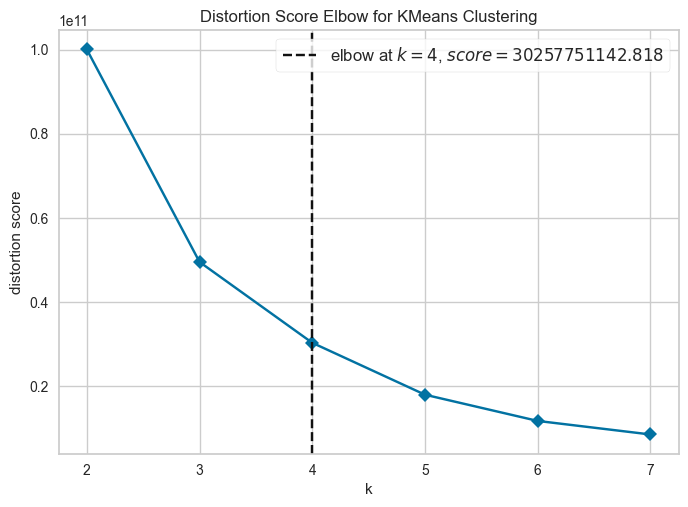

In [47]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False )
kmeans.fit(X)
kmeans.show();

- The smaller the WSS, the smaller the sum of the distances within the clusters, which means that the points are closer to their centroid, so the cluster is more compact!

- even though with more cluster (4, 5 ou 6), we would have (a bit) more condensed clusters, the optimized number of cluster

## Silhouette Score

C:\Users\PC\projetos\clusterizacao\cluster\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC\projetos\clusterizacao\cluster\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC\projetos\clusterizacao\cluster\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC\projetos\clusterizacao\cluster\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

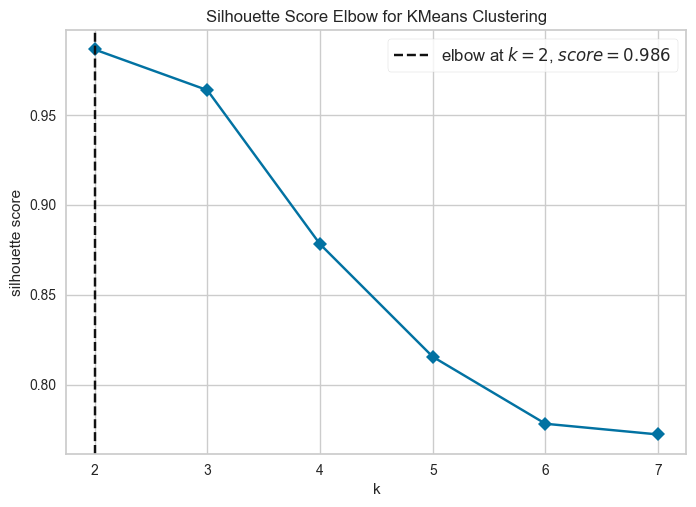

In [48]:
#calculate silhouette score also with yellowbrick library
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

Being SS=1 the best clustering result:

- with 2 clusters, the result is 0.99 (awesome)
- with 3 clusters, it is 0,96 (awesome)
- with 4, or 5, we still have SS > 0.8, it's still very good!
According to SS, the ideal cluster number is 2, but fur business porposes, it's interesting to have at least 3 groups or more.

## Silhouette Analysis

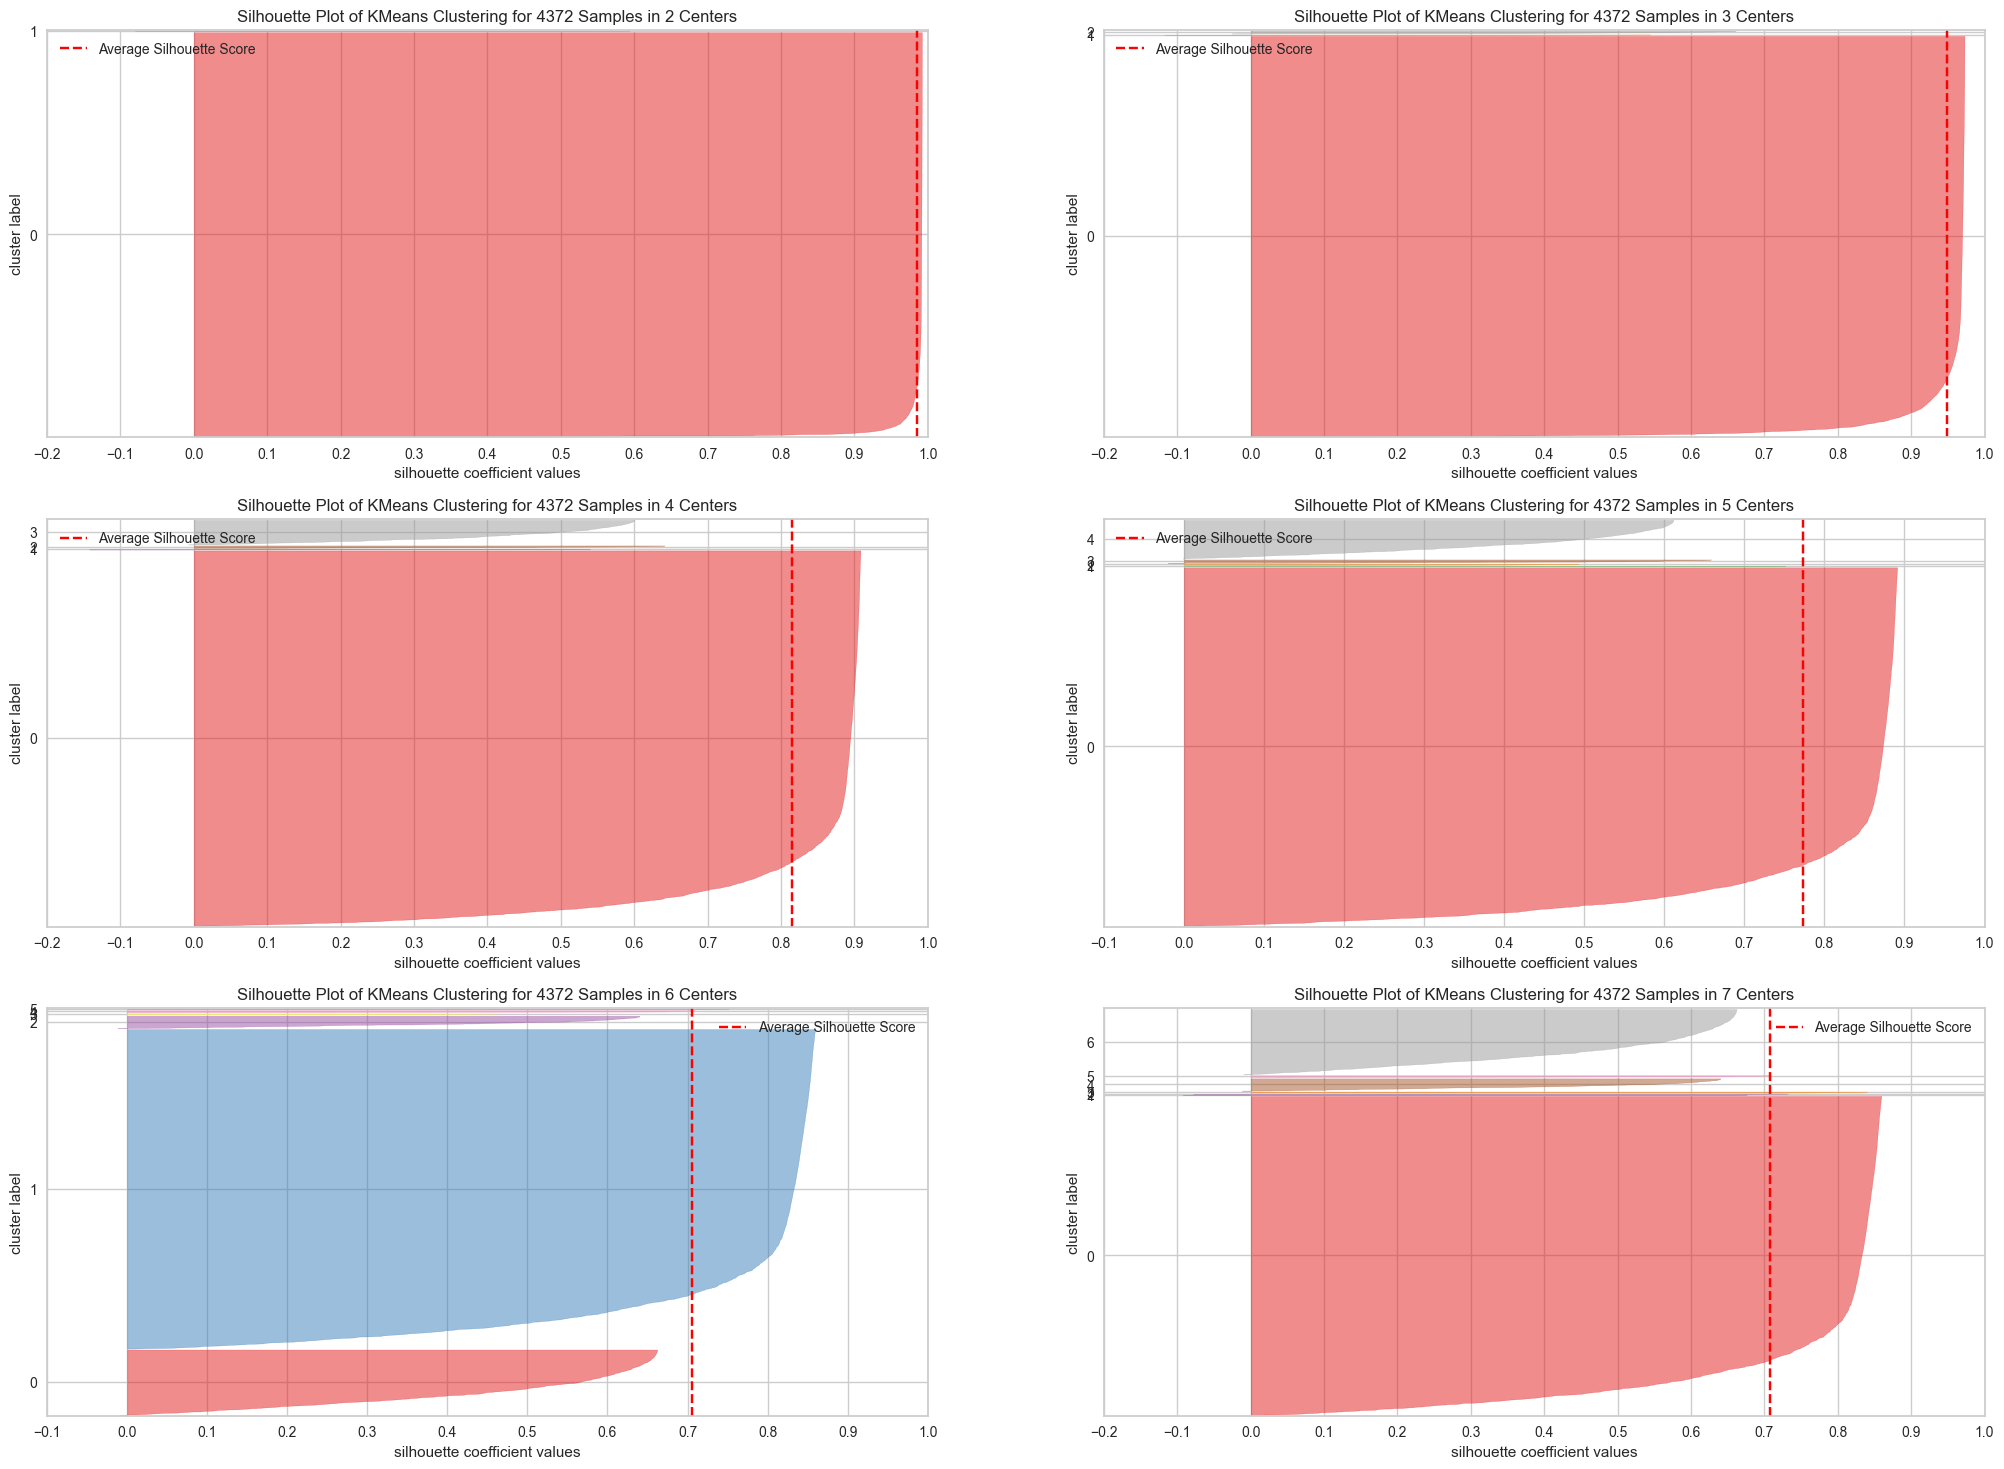

In [51]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

k = [2,3,4,5,6,7]
for k in clusters:
    km = c.KMeans(n_clusters=k, init='random',n_init=10, max_iter=100, random_state=42)
    q, mod =divmod(k, 2) #usar divisão por moda pra plotar os gráficos
    
    #Plot Silhouette
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

In this first analysis, it is possible to notice that the clusters are not well divided

# Model Training

# Cluster Analysis Variable